
Cargando modelo DQN...
Modelo cargado: ../results/models/dqn/best_model/best_model.zip
→ Episodio 1/20
→ Episodio 2/20
→ Episodio 3/20
→ Episodio 4/20
→ Episodio 5/20
→ Episodio 6/20
→ Episodio 7/20
→ Episodio 8/20
→ Episodio 9/20
→ Episodio 10/20
→ Episodio 11/20
→ Episodio 12/20
→ Episodio 13/20
→ Episodio 14/20
→ Episodio 15/20
→ Episodio 16/20
→ Episodio 17/20
→ Episodio 18/20
→ Episodio 19/20
→ Episodio 20/20


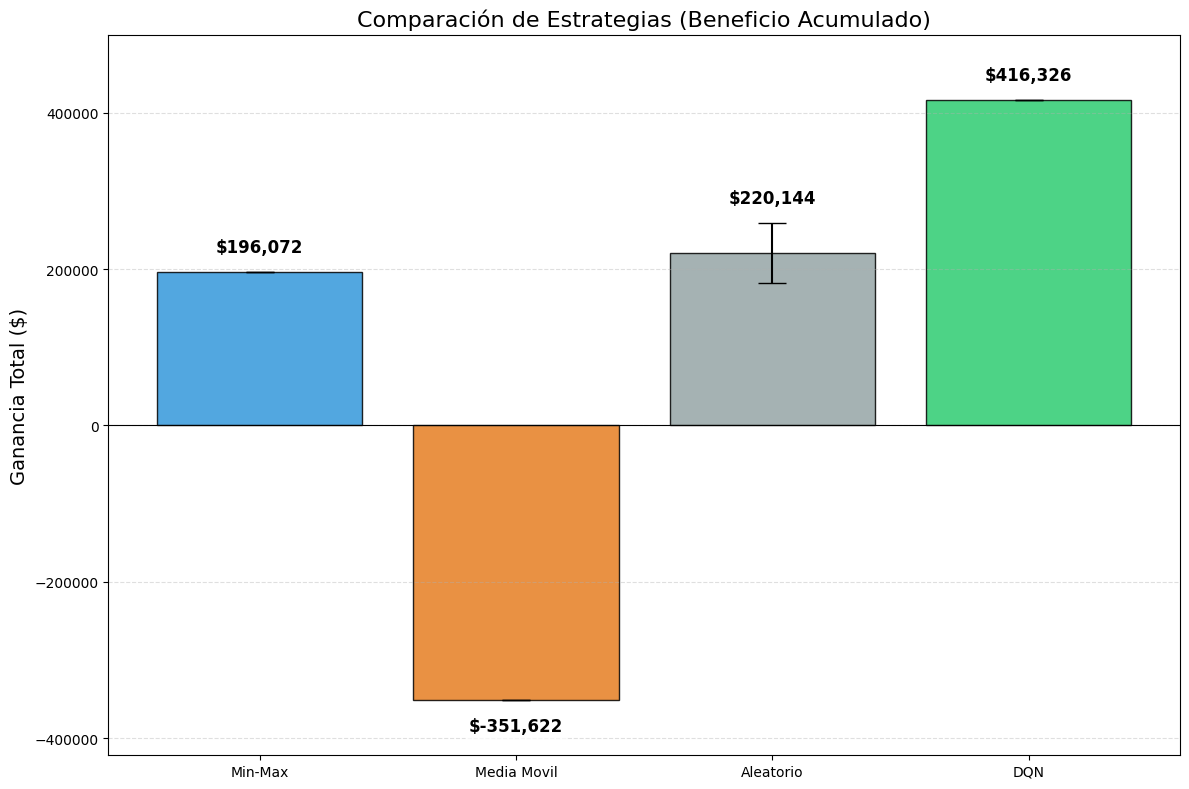


Resumen:
Min-Max: promedio = 196072.41
Media Movil: promedio = -351621.59
Aleatorio: promedio = 220144.30
DQN: promedio = 416326.47


In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.environment_dqn import RetailEnvDQN
from stable_baselines3 import DQN

output_path = '../results/plots/benchmark/' # Para guardar los plots
output_dir = os.path.dirname(output_path)
os.makedirs(output_dir, exist_ok=True)

# 1. Carga de Datos (igual que en training_dqn)
def cargar_datos_csv(ruta_csv):
    df_raw = pd.read_csv(ruta_csv)
    
    df_ordenado = pd.DataFrame()
    df_ordenado["dummy_inv"] = 0.0

    df_ordenado["forecast"] = df_raw["Demand Forecast"]
    df_ordenado["price"] = df_raw["Price"]
    df_ordenado["discount"] = df_raw["Discount"]
    df_ordenado["holiday"] = df_raw["Holiday/Promotion"]
    df_ordenado["competitor"] = df_raw["Competitor Pricing"]
    df_ordenado["weather"] = df_raw["Weather_Code"]
    df_ordenado["seasonality"] = df_raw["Seasonality_Code"]
    df_ordenado["units_sold"] = df_raw["Units Sold"]

    return df_ordenado.values.astype(np.float32)


# 2. Políticas de referencias (baselines)
def obtener_accion_mas_cercana(cantidad_deseada, action_values):
    idx = (np.abs(action_values - cantidad_deseada)).argmin()
    return idx

def politica_sS(env, s_min, S_max):
    obs, _ = env.reset()
    done = False
    raw_profit = 0
    
    while not done:
        inv = env.inventario
        if inv < s_min:
            qty = S_max - inv
            action = obtener_accion_mas_cercana(qty, env.action_values)
        else:
            action = 0

        _, _, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        raw_profit += info["raw_reward"]

    return raw_profit

def politica_media_movil(env, window=7):
    obs, _ = env.reset()
    done = False
    hist = [0] * window
    raw_profit = 0

    while not done:
        avg_sales = sum(hist) / len(hist)
        action = obtener_accion_mas_cercana(avg_sales, env.action_values)

        _, _, terminated, truncated, info = env.step(action)
        hist.pop(0)
        hist.append(info["vendido"])

        done = terminated or truncated
        raw_profit += info["raw_reward"]

    return raw_profit


# 3. Ejecución de Benchmark
def ejecutar_benchmark(test_data, modelo_dqn_path, n_episodios=20):
    resultados = {
        "Min-Max": [],
        "Media Movil": [],
        "Aleatorio": [],
        "DQN": [],
    }

    # Cargar el DQN entrenado
    print("\nCargando modelo DQN...")
    model = DQN.load(modelo_dqn_path)
    print(f"Modelo cargado: {modelo_dqn_path}")

    for ep in range(n_episodios):
        print(f"→ Episodio {ep+1}/{n_episodios}")

        # Baseline Min-Max
        env = RetailEnvDQN(test_data)
        env.disable_random_reset = True
        env.fixed_start = 0
        resultados["Min-Max"].append(politica_sS(env, 200, 800))

        # Baseline Media Móvil
        env = RetailEnvDQN(test_data)
        env.disable_random_reset = True
        env.fixed_start = 0
        resultados["Media Movil"].append(politica_media_movil(env))

        # Aleatorio
        env = RetailEnvDQN(test_data)
        env.disable_random_reset = True
        env.fixed_start = 0
        obs, _ = env.reset()
        done = False
        raw = 0
        while not done:
            action = env.action_space.sample()
            _, _, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            raw += info["raw_reward"]
        resultados["Aleatorio"].append(raw)

        # DQN 
        env = RetailEnvDQN(test_data)
        env.disable_random_reset = True
        env.fixed_start = 0
        obs, _ = env.reset()
        done = False
        raw = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, _, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            raw += info["raw_reward"]
        resultados["DQN"].append(raw)

    return resultados


# 4. Visualización
def graficar_resultados(resultados):
    
    promedios = {k: np.mean(v) for k, v in resultados.items()}
    stds = {k: np.std(v) for k, v in resultados.items()}

    nombres = list(promedios.keys())
    vals = list(promedios.values())
    errs = list(stds.values())

    plt.figure(figsize=(12, 8))
    
    # Colores distintos para diferenciar (MinMax=Azul, MA=Naranja, Random=Gris, DQN=Verde)
    colores = ['#3498db', '#e67e22', '#95a5a6', '#2ecc71']
    
    # Crear las barras guardando el objeto 'barras' para iterar sobre él después
    barras = plt.bar(nombres, vals, yerr=errs, capsize=10, alpha=0.85, 
                     color=colores, edgecolor='black', linewidth=1)

    plt.title("Comparación de Estrategias (Beneficio Acumulado)", fontsize=16)
    plt.ylabel("Ganancia Total ($)", fontsize=14)
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.axhline(0, color='black', linewidth=0.8) # Línea en el cero para referencia

    # Colocar los números ordenados y sin que choquen
    # Calculamos un margen dinámico (5% del valor máximo) para separar el texto
    margen_y = max(np.abs(vals)) * 0.05
    
    for barra, error in zip(barras, errs):
        altura = barra.get_height()
        
        # Determinar posición Y: 
        # Si es positivo: Altura + Error + Margen
        # Si es negativo: Altura - Error - Margen
        if altura >= 0:
            y_pos = altura + error + margen_y
            va = 'bottom' # Alinear texto desde abajo
        else:
            y_pos = altura - error - margen_y
            va = 'top'    # Alinear texto desde arriba

        # pone signo peso, comas de mil y 0 decimales
        etiqueta = f"${altura:,.0f}"

        plt.text(
            barra.get_x() + barra.get_width() / 2, # Posición X (centro de la barra)
            y_pos,                                 # Posición Y calculada
            etiqueta,
            ha='center', 
            va=va, 
            fontweight='bold', 
            fontsize=12,
            color='black',
            # Esto crea una cajita blanca detrás del número para que se lea perfecto
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.3')
        )

    # Ajustar límites del gráfico para que no se corten los textos de arriba/abajo
    # Obtenemos el punto más alto y más bajo (considerando el error)
    max_y = max([v + e for v, e in zip(vals, errs)])
    min_y = min([v - e for v, e in zip(vals, errs)])
    
    # Le damos un 15% extra de espacio arriba y abajo
    plt.ylim(min(0, min_y) * 1.2, max(0, max_y) * 1.2)

    plt.tight_layout()
    plt.savefig(output_path + 'resultados.png')
    plt.show()


# 5. Main
if __name__ == "__main__":
    data = cargar_datos_csv("../data/data_train.csv")

    # Split Train/Test 
    train = data[:2924]
    test = data[2924:]

    resultados = ejecutar_benchmark(
        test,
        modelo_dqn_path="../results/models/dqn/best_model/best_model.zip",
        n_episodios=20,
    )

    graficar_resultados(resultados)
    print("\nResumen:")
    for k, v in resultados.items():
        print(f"{k}: promedio = {np.mean(v):.2f}")
